In [1]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
def gamma_calc(m1, m2, m3, m4, en1, Q):
    """
    Calculates the gamma value for a given nuclear reaction based on the input parameters.
    Uses notation from "The Atomic Nucleus", Chapter 12: Conservation Laws for Nuclear Reactions, problem 17

    Args:
        m1 (float): Mass of particle 1.
        m2 (float): Mass of particle 2.
        m3 (float): Mass of particle 3.
        m4 (float): Mass of particle 4.
        en1 (float): Energy of particle 1.
        Q (float): Q-value of the reaction.

    Returns:
        float: The gamma value of the reaction.
    """
    # Calculate gamma value using the input parameters.
    return np.sqrt(m1*m3/(m2*m4)*en1/(en1+Q*(1+m1/m2)))

def en3_calc(m1, m3, m4, theta_L, Q, en1):
    """
        Calculate the energy of a particle produced.

        Args:
            m1 (float): mass of the initial particle
            m3 (float): mass of the target particle
            m4 (float): mass of the final particle
            theta_L (float or array-like): scattering angle in degrees
            Q (float): Q-value of reaction
            en1 (float): energy of the initial particle

        Returns:
            np.array: array of the final particle energies for each scattering angle in theta_L
        """

    # Convert theta_L to radians for later use in calculations.
    theta_L = np.radians(theta_L)

    # Calculate intermediate quantities v and w.
    v = np.sqrt(m1*m3*en1)/(m3+m4)*np.cos(theta_L)
    w = (m4*Q+en1*(m4-m1))/(m3+m4)
    
    # Calculate the possible positive and negative parts in the energy calculation.
    en_test_p = v**2+w
    en_test_n = v**2+w

    # Check if the energies are real by setting negative values to NaN.
    en_test_p[en_test_p < 0] = np.nan
    en_test_n[en_test_n < 0] = np.nan

    # Calculate the final energies of the particle by adding/subtracting the square root of the positive/negative energy part.
    e3p_sqrt = v + np.sqrt(en_test_p)
    e3n_sqrt = v - np.sqrt(en_test_n)

    # Check if energies are negative by setting negative values to NaN.
    e3p_sqrt[ e3p_sqrt < 0] = np.nan
    e3n_sqrt[e3n_sqrt < 0] = np.nan

    # Initialize an array of NaNs with the same length as theta_L.
    e3_sqrt = np.full(len(theta_L), np.nan)

    # Fill the final e3_sqrt array with the energy values.
    e3_sqrt[~np.isnan(e3p_sqrt)] = e3p_sqrt[~np.isnan(e3p_sqrt)]
    e3_sqrt[~np.isnan(e3n_sqrt)] = e3n_sqrt[~np.isnan(e3n_sqrt)]

    # Find the indices where both e3p_sqrt and e3n_sqrt are not NaN.
    w_e3p_sqrt = np.where(~np.isnan(e3p_sqrt) == True)[0]
    w_e3n_sqrt = np.where(~np.isnan(e3n_sqrt) == True)[0]
    #Make an array of indexes for where both e3p_sqrt and e3n_sqrt are possible
    w_both = np.array(np.intersect1d(w_e3p_sqrt, w_e3n_sqrt))

    if len(w_both) > 0:

        # Create a 2D array of the positive and negative energies for each angle where both values are valid.
        mixed = np.array([e3p_sqrt[w_both], e3n_sqrt[w_both]])

        # Randomly choose between the positive and negative energies for each angle where both values are valid.
        decide = np.random.randint(0,2,len(w_both))

        # For angles where both positive and negative energies are valid, choose between the two randomly.
        e3_sqrt[w_both] = np.choose(decide, mixed)

    # Return the final particle energy values.
    return e3_sqrt**2

def theta_LtoC(theta_C, gamma):
    """
    Convert theta_C in the original coordinate system to theta_L in the new coordinate system using the gamma value.

    Args:
    - theta_C (float or array): The angle(s) in degrees in the original coordinate system.
    - gamma (float): The gamma value used in the conversion.

    Returns:
    - theta_L (float or array): The corresponding angle(s) in degrees in the new coordinate system.
    """
    # Calculate theta_L using the input parameters.
    theta_L = np.degrees(np.arctan(np.sin(np.radians(theta_C))/(gamma+np.cos(np.radians(theta_C)))))

    # Check if the angle is 0 or 180 degrees in the original coordinate system.
    # If so, set the corresponding angle in the new coordinate system to 0 or 180 degrees.
    theta_L[theta_C == 0] = 0
    theta_L[theta_C == 180] = 180

    # Add 180 degrees to the angle if it is negative.
    theta_L[theta_L < 0] = theta_L[theta_L < 0] + 180

    return theta_L

def en4_calc(en1, en3, Q):
    """
    Calculates the energy of particle 4 based on the energies of particles 1 and 3, and the Q-value of the reaction.

    Args:
        en1 (float): Energy of particle 1.
        en3 (float): Energy of particle 3.
        Q (float): Q-value of the reaction.

    Returns:
        float: Energy of particle 4.
    """
    return en1 + Q - en3

def phi_L_calc(theta_L, m3, en3, m4, en4):
    """
    Calculates the phi_L angle given the theta_L angle and the energies and masses of the particles involved.

    Args:
    theta_L (float or numpy.ndarray): The theta_L angle(s) in degrees.
    m3 (float): The mass of particle 3.
    en3 (float): The energy of particle 3.
    m4 (float): The mass of particle 4.
    en4 (float): The energy of particle 4.

    Returns:
    phi_L (float or numpy.ndarray): The phi_L angle(s) in degrees.
    """
    # Calculate the constant factor in the formula.
    constant = np.sqrt(2*m3*en3)/np.sqrt(2*m4*en4)

    # Calculate the phi_L angle(s) using the input theta_L angle(s).
    phi_L = np.degrees(np.arcsin(np.clip(constant*np.sin(np.radians(theta_L)), -1, 1)))

    return phi_L

def gamma_disintegration(mi, m1, m2, eni, Q):
    """
    Calculates the gamma value for a nuclear disintegration process.

    Args:
    mi (float): The initial mass of the nucleus before disintegration.
    m1 (float): The mass of one of the resulting nuclei after disintegration.
    m2 (float): The mass of the other resulting nucleus after disintegration.
    eni (float): The initial energy of the nucleus before disintegration.
    Q (float): The energy released during the disintegration process.

    Returns:
    float: The gamma value for the disintegration process.
    """
    return m1/np.sqrt(m1*m2*Q/(m1+m2))*np.sqrt(eni/mi) #calculate gamma

def convert_to_cartesian_zx(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates in a z-x plane.
    
    Args:
    r (float or array-like): radial distance from the origin
    theta (float or array-like): polar angle in degrees
    
    Returns:
    x (float or array-like): x-coordinate(s)
    y (float or array-like): y-coordinate(s)
    z (float or array-like): z-coordinate(s)
    """
    
    # Calculate the x-coordinate using sine function.
    x = r*np.sin(np.radians(theta))

    # Initialize y-coordinate with zeros.
    # This assumes a z-x plane where the y-coordinate is 0.
    if isinstance(theta, (list, tuple, np.ndarray)):
        y = np.zeros_like(theta)
    else:
        y = 0

    # Calculate the z-coordinate using cosine function.
    z = r*np.cos(np.radians(theta))

    # Return the x, y, and z coordinates.
    return x,y,z

def rotate_z(x, y, z, theta):
    """
    Rotate the given 3D points around the z-axis by the given angle.
    
    Args:
    x (numpy.ndarray): An array of x-coordinates of the 3D points.
    y (numpy.ndarray): An array of y-coordinates of the 3D points.
    z (numpy.ndarray): An array of z-coordinates of the 3D points.
    theta (float): The angle in degrees to rotate the points.
    
    Returns:
    tuple: A tuple of three numpy.ndarray objects representing the x, y, and z coordinates of the rotated points.
    """
    
    # Note this rotates cw staring at the x-y plane
    # Stack x, y, z along the first axis to create a (N, 3) shaped array `points`
    points = np.stack((x, y, z), axis=1)

    # Calculate the cosine and sine of the rotation angle `theta`
    cos_theta = np.cos(np.radians(theta))
    sin_theta = np.sin(np.radians(theta))

    # Create the rotation matrix around the z-axis
    # The shape of the rotation matrix is (3, 3, N) where N is the number of points
    rotation_matrix = np.stack((
        np.stack((cos_theta, -sin_theta, np.zeros_like(theta)), axis=1),
        np.stack((sin_theta, cos_theta, np.zeros_like(theta)), axis=1),
        np.stack((np.zeros_like(theta), np.zeros_like(theta), np.ones_like(theta)), axis=1)
    ), axis=2)

    # Perform matrix multiplication between the rotation matrix and the points
    rotated_points = np.matmul(rotation_matrix, points[:, :, np.newaxis])

    # Extract the rotated x, y, and z values from the rotated_points
    rx = rotated_points[:, 0, 0]
    ry = rotated_points[:, 1, 0]
    rz = rotated_points[:, 2, 0]

    # Return the rotated x, y, and z values
    return rx, ry, rz

def rotate_y(x, y, z, theta):
    """
    Rotates the coordinates around the y-axis by an angle theta.
    
    Args:
    x (numpy.ndarray): x-coordinates of the points
    y (numpy.ndarray): y-coordinates of the points
    z (numpy.ndarray): z-coordinates of the points
    theta (float): angle of rotation in degrees
    
    Returns:
    A tuple containing:
        - rx (numpy.ndarray): x-coordinates of the rotated points
        - ry (numpy.ndarray): y-coordinates of the rotated points
        - rz (numpy.ndarray): z-coordinates of the rotated points
    """
    # Stack x, y, z along the first axis to create a (N, 3) shaped array `points`
    points = np.stack((x, y, z), axis=1)

    # Calculate the cosine and sine of the rotation angle `theta`
    cos_theta = np.cos(np.radians(theta))
    sin_theta = np.sin(np.radians(theta))

    # Create the rotation matrix around the y-axis
    # The shape of the rotation matrix is (3, 3, N) where N is the number of points
    rotation_matrix = np.stack((
        np.stack((cos_theta, np.zeros_like(theta), sin_theta), axis=1),
        np.stack((np.zeros_like(theta), np.ones_like(theta), np.zeros_like(theta)), axis=1),
        np.stack((-sin_theta, np.zeros_like(theta), cos_theta), axis=1)
    ), axis=2)

    # Perform matrix multiplication between the rotation matrix and the points
    rotated_points = np.matmul(rotation_matrix, points[:, :, np.newaxis])

    # Extract the rotated x, y, and z values from the rotated_points
    rx = rotated_points[:, 0, 0]
    ry = rotated_points[:, 1, 0]
    rz = rotated_points[:, 2, 0]

    # Return the rotated x, y, and z values
    return rx, ry, rz

def convert_to_cartesian(r, theta, phi):
    """
    Convert polar coordinates to Cartesian coordinates.

    Args:
    r (float or array-like): radial distance from the origin
    theta (float or array-like): polar angle in radians
    phi (float or array-like): azimuthal angle in radians

    Returns:
    x (float or array-like): x-coordinate in Cartesian coordinates
    y (float or array-like): y-coordinate in Cartesian coordinates
    z (float or array-like): z-coordinate in Cartesian coordinates
    """
    # Calculate the x-coordinate using sine and cosine functions.
    x = r*np.sin(theta)*np.cos(phi)

    # Calculate the y-coordinate using sine and sine functions.
    y = r*np.sin(theta)*np.sin(phi)

    # Calculate the z-coordinate using cosine function.
    z = r*np.cos(theta)

    # Return the x, y, and z coordinates.
    return x, y, z

def angle_between(v1, v2):
    """
    Calculate the angle between two vectors v1 and v2.

    Args:
    v1 (array-like): Array of shape (N,3) representing N vectors with 3 components.
    v2 (array-like): Array of shape (N,3) representing N vectors with 3 components.

    Returns:
    array-like: Array of shape (N,) containing the angles in degrees between the two vectors.
    """
    # Normalize the vectors to unit vectors
    u1 = v1/np.linalg.norm(v1, axis=1)[:,np.newaxis]
    u2 = v2/np.linalg.norm(v2, axis=1)[:,np.newaxis]

    # Calculate the dot product between the two unit vectors to get cosine of the angle
    cos_theta = np.dot(u1,u2.T)

    # Use arccos to get the angle in radians and convert to degrees
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def elastic_calc(m1, m2, theta_C, en1):
    """
    Calculates the energy and angle of a scattered proton in an elastic scattering event.

    Args:
        m1 (float): mass of incident particle (in atomic mass units)
        m2 (float): mass of target particle (in atomic mass units)
        theta_C (float): angle of incidence (in degrees)
        en1 (float): energy of incident particle (in MeV)

    Returns:
        Tuple[float, float]: A tuple containing the final energy of the scattered proton (in MeV)
        and the corresponding angle of scattering (in degrees).
    """

    # Convert the scattering angle from degrees to radians.
    theta_C = np.radians(theta_C)
    
    # Calculate the initial velocity of the incoming proton using its kinetic energy.
    v_in = np.sqrt(2/m1*en1)

    # Calculate the final velocity of the scattered proton using the conservation of momentum and energy.
    v_out = np.sqrt(v_in**2*(1-2*(1-np.cos(theta_C))*m1*m2/((m1+m2)**2)))

    # Calculate the final kinetic energy of the scattered proton.
    en_f = 1/2*m1*v_out**2

    # Calculate the lab angle of the scattered proton.
    theta_L = np.arctan(np.sin(theta_C)/(m1/m2+np.cos(theta_C)))

    # Return the final kinetic energy and lab angle of the scattered proton.
    return en_f, np.degrees(theta_L)

def diff_cross_section(z1, z2, m1, m2, en, theta):
    """
    Calculates the differential cross section for Rutherford scattering.

    Args:
    z1 (int): atomic number of the incident particle
    z2 (int): atomic number of the target particle
    m1 (float): mass of the incident particle (units: arbitrary, but must be consistent with m2)
    m2 (float): mass of the target particle (units: arbitrary, but must be consistent with m1)
    en (float): kinetic energy of the incident particle in MeV
    theta (float): scattering angle of the incident particle in degrees
    
    Returns:
    float: differential cross section in units of cm^2/sr
    """

    # Define the electric charge squared constant in MeV cm
    electric_charge_sq = 1.4398*10**-13 #MeV cm

    # Convert the scattering angle from degrees to radians
    theta = np.radians(theta)

    # Calculate the first factor in the equation using the input parameters
    first_factor = ((z1*z2*electric_charge_sq)/(4*en))**2

    # Calculate the second factor in the equation using the input parameter
    second_factor = 4/(np.sin(theta)**4)

    # Calculate the third factor's numerator in the equation using the input parameters
    third_factor_numerator = ((1-((m1/m2)*np.sin(theta))**2)**(1/2)+np.cos(theta))**2

    # Calculate the third factor's denominator in the equation using the input parameters
    third_factor_denominator =(1-((m1/m2)*np.sin(theta))**2)**(1/2)

    # Calculate the differential cross section using the first, second, and third factors
    return first_factor*second_factor*third_factor_numerator/third_factor_denominator

def kinematic_factor(m1, m2, theta):
    """
    Calculates the kinematic factor for scattering between two particles with masses m1 and m2 and scattering angle theta.

    Args:
    - m1 (float): mass of the first particle (units: arbitrary, but must be consistent with m2)
    - m2 (float): mass of the second particle (units: arbitrary, but must be consistent with m1)
    - theta (float): scattering angle in degrees (units: degrees)

    Returns:
    - float: the kinematic factor for the given masses and scattering angle (ratio)
    """

    # convert scattering angle from degrees to radians
    theta = np.radians(theta)

    # calculate numerator and denominator of kinematic factor equation
    numerator = ((1-(m1/m2)**2*np.sin(theta)**2)**(1/2) + (m1/m2)*np.cos(theta))
    denominator = 1 + m1/m2

    # calculate and return the kinematic factor
    return (numerator/denominator)**2

def solid_angle(det_distance, det_area):
    """
    Calculates the solid angle for a detector with a given distance and area.
    
    Args:
    - det_distance (float): the distance between the detector and the target in centimeters.
    - det_area (float): the area of the detector in square centimeters.
    
    Returns:
    - solid_angle (float): the solid angle subtended by the detector in steradians.
    """
    a = np.sqrt(det_area/np.pi) # Calculate the radius of the detector from its area

    # Calculate the half-angle subtended by the detector using the inverse tangent function
    theta = np.arctan(np.clip(a/det_distance, -1, 1))

    return 2*np.pi*(1-np.cos(theta)) # Calculate the solid angle

In [37]:
mp=1.00727646 # mass of proton
mB11=11.0093052 # mass of B11
mAlpha=4.002602 # mass of alpha
mBe8=8.00530510 # mass of Be8
QBe8=8.586 # Q value of Be8
QBe8s=5.65 # Q value of excited Be8
Qa=0.092 # Q value for alpha_12 from non-excited Be8
Qas=3.028 # Q value for alpha_12 from excited Be8
########
enp = 0.66 # MeV energy of proton
########
zp = 1 # atomic number for H
zB = 5 # atomic number for B
atoms_per_vol = 1.3091E+23 # atoms/cm^3
thickness = 1*10**-5 #cm
atoms_per_area = atoms_per_vol*thickness

#set up detectors
d = 2.61 # cm (2.61 cm) (Distance to the detector)

pL = d/np.sqrt(3)
detector_x = np.array([pL,pL,pL,pL,-pL,-pL,-pL,-pL])
detector_y = np.array([pL,-pL,pL,-pL,-pL,pL,-pL,pL])
detector_z = np.array([pL,pL,-pL,-pL,-pL,-pL,pL,pL])

detector_area = 0.13#.066 #cm^2 (2.4 mm * 2.8 mm)
r_detector = np.sqrt(detector_area/np.pi) #radius of detector assuming circle
min_angle = np.degrees(np.arctan(np.clip(r_detector/d,-1,1))) #minimum angle that will go into the detector

In [38]:
min_angle

4.456580885436506

In [39]:
# Set total number of reactions
total_reactions = 1*10**8

# Generate distributed random angles for the first reaction
x_rand = np.random.rand(1,total_reactions)
theta_C_array1 = np.arccos(1-2*x_rand)*180/np.pi
theta_C_array1 = theta_C_array1[0]
#theta_C_array1 = np.random.uniform(0,180,total_reactions)

# Generate uniformly distributed random angles for the first and second reaction
r1_phiL = np.random.uniform(0,360,total_reactions)
r2_phiL = np.random.uniform(0,360,total_reactions)

# Randomly select Q values for the first reaction from QBe8 and QBe8s with probabilities 0.01 and 0.99 respectively
Q1 = np.random.choice([QBe8,QBe8s],total_reactions,p=[0.01,0.99])

# Calculate gamma1, theta_L1, en_alpha_01, en_Be8, and phi_L1 for the first reaction
gamma1 = gamma_calc(mp, mB11, mAlpha, mAlpha, enp, Q1)
theta_L1 = theta_LtoC(theta_C_array1, gamma1)
en_alpha_01 = en3_calc(mp, mAlpha, mBe8, theta_L1, Q1, enp)
en_Be8 = en4_calc(enp, en_alpha_01, Q1)
phi_L1 = phi_L_calc(theta_L1, mAlpha, en_alpha_01, mBe8, en_Be8)

# Generate uniformly distributed random angles for the second reaction
x_rand = np.random.rand(1,total_reactions)
theta_C_array2 = np.arccos(1-2*x_rand)*180/np.pi
theta_C_array2 = theta_C_array2[0]
#theta_C_array2 = np.random.uniform(0,180,total_reactions)

# Set Q2 values for the second reaction
Q2 = np.full((len(Q1)),Qas)
Q2[Q1 == QBe8] = Qa

# Calculate gamma2, theta_L2, en_alpha_11, en_alpha_12, and phi_L2 for the second reaction
gamma2 = gamma_disintegration(mBe8, mAlpha, mAlpha, en_Be8, Q2)
theta_L2 = theta_LtoC(theta_C_array2, gamma2)
en_alpha_11 = en3_calc(mBe8, mAlpha, mAlpha, theta_L2, Q2, en_Be8)
en_alpha_12 = en4_calc(en_Be8, en_alpha_11, Q2)
phi_L2 = phi_L_calc(theta_L2, mAlpha, en_alpha_11, mAlpha, en_alpha_12)

# Convert to 3D coordinates
# First reaction
alpha_01_x, alpha_01_y, alpha_01_z = convert_to_cartesian_zx(d, theta_L1)
Be8_x, Be8_y, Be8_z = convert_to_cartesian_zx(d, 360 - phi_L1)

# Rotate the coordinate system for the first reaction
alpha_01_x, alpha_01_y, alpha_01_z = rotate_z(alpha_01_x, alpha_01_y, alpha_01_z, r1_phiL)
Be8_x, Be8_y, Be8_z = rotate_z(Be8_x, Be8_y, Be8_z, r1_phiL)

# Second reaction

# Convert spherical coordinates to Cartesian coordinates for alpha particles 11 and 12
alpha_11_x, alpha_11_y, alpha_11_z = convert_to_cartesian_zx(d, theta_L2)
alpha_12_x, alpha_12_y, alpha_12_z = convert_to_cartesian_zx(d, 360 - phi_L2)

# Rotate the coordinate system for the second reaction
alpha_11_x, alpha_11_y, alpha_11_z = rotate_z(alpha_11_x, alpha_11_y, alpha_11_z, r2_phiL)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_z(alpha_12_x, alpha_12_y, alpha_12_z, r2_phiL)

alpha_11_x, alpha_11_y, alpha_11_z = rotate_y(alpha_11_x, alpha_11_y, alpha_11_z, phi_L1)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_y(alpha_12_x, alpha_12_y, alpha_12_z, phi_L1)

alpha_11_x, alpha_11_y, alpha_11_z = rotate_z(alpha_11_x, alpha_11_y, alpha_11_z, r1_phiL)
alpha_12_x, alpha_12_y, alpha_12_z = rotate_z(alpha_12_x, alpha_12_y, alpha_12_z, r1_phiL)

# Check if alpha particles go into the detector

# Convert alpha particle coordinates to matrices
alpha_01_mat = np.stack((alpha_01_x, alpha_01_y, alpha_01_z), axis=1)
alpha_11_mat = np.stack((alpha_11_x, alpha_11_y, alpha_11_z), axis=1)
alpha_12_mat = np.stack((alpha_12_x, alpha_12_y, alpha_12_z), axis=1)
det_mat = np.stack((detector_x, detector_y, detector_z), axis=1)

# Determine which alpha particles hit the detectors
alpha_01_n, alpha_01_d = np.where(angle_between(alpha_01_mat, det_mat) <= min_angle)
alpha_11_n, alpha_11_d = np.where(angle_between(alpha_11_mat, det_mat) <= min_angle)
alpha_12_n, alpha_12_d = np.where(angle_between(alpha_12_mat, det_mat) <= min_angle)

# Combine the hit reactions into a single list and remove duplicates
reactions_hit = np.unique(np.sort(np.hstack((alpha_01_n, alpha_11_n, alpha_12_n)).ravel()))

# Identify alpha particles that hit more than one detector
u, i = np.unique(np.sort(np.hstack((alpha_01_n, alpha_11_n, alpha_12_n)).ravel()), return_inverse=True)
duplicates = u[np.bincount(i) > 1]

# Create a boolean array that indicates which alpha particles hit multiple detectors
multiple_hits = np.full(np.shape(en_alpha_01), False)
multiple_hits[duplicates] = True
multiple_hits = multiple_hits[reactions_hit]

# Assign detector numbers to each alpha particle that hit a detector
alpha_01_det = np.full(np.shape(en_alpha_01), np.nan) # Create an array of NaN values of the same shape as en_alpha_01
alpha_01_det[alpha_01_n] = alpha_01_d # Assign the detector number to alpha_01_det array at the positions where alpha_01_n has a non-zero value
alpha_01_det = alpha_01_det[reactions_hit] # Slice the alpha_01_det array to only include the indices where a reaction hit a detector

alpha_11_det = np.full(np.shape(en_alpha_11), np.nan) # Create an array of NaN values of the same shape as en_alpha_11
alpha_11_det[alpha_11_n] = alpha_11_d # Assign the detector number to alpha_11_det array at the positions where alpha_11_n has a non-zero value
alpha_11_det = alpha_11_det[reactions_hit] # Slice the alpha_11_det array to only include the indices where a reaction hit a detector

alpha_12_det = np.full(np.shape(en_alpha_12), np.nan) # Create an array of NaN values of the same shape as en_alpha_12
alpha_12_det[alpha_12_n] = alpha_12_d # Assign the detector number to alpha_12_det array at the positions where alpha_12_n has a non-zero value
alpha_12_det = alpha_12_det[reactions_hit] # Slice the alpha_12_det array to only include the indices where a reaction hit a detector

# Create a list of tuples containing energies and detector numbers of each alpha particle that hit a detector
alpha_tuples = list(zip(en_alpha_01[reactions_hit], en_alpha_11[reactions_hit], en_alpha_12[reactions_hit], alpha_01_det, alpha_11_det, 
                    alpha_12_det, multiple_hits, alpha_01_mat[reactions_hit], alpha_11_mat[reactions_hit], alpha_12_mat[reactions_hit]))

# Create a Pandas DataFrame using the alpha_tuples list, where each column corresponds to a specific property of the alpha particles that hit a detector.
alpha_df = pd.DataFrame(alpha_tuples, columns=["en_a_01", "en_a_11", "en_a_12", "a_01_det", "a_11_det", "a_12_det", "multiple_det", "a01_vel",
                                               "a11_vel", "a12_vel"])



In [40]:
alpha_df

,en_a_01,en_a_11,en_a_12,a_01_det,a_11_det,a_12_det,multiple_det,a01_vel,a11_vel,a12_vel
0,4.174510,1.710097,3.453393,NaN,NaN,7.0,False,"[2.538296924174985, -0.5977130115431825, 0.109...","[-1.7967707806403794, -1.2767800723552116, -1....","[-1.5263711139921086, 1.5556317844877785, 1.43..."
1,4.465401,4.354394,0.518205,NaN,6.0,5.0,True,"[1.9312747302437114, 1.021580409725305, 1.4278...","[-1.472769134638004, -1.5789635647056595, 1.46...","[-1.6258195934739368, 1.4587681737153413, -1.4..."
2,4.487167,3.231279,1.619554,6.0,NaN,NaN,False,"[-1.512501356081569, -1.4848396196101232, 1.52...","[2.292375208880787, 1.1556867482707909, -0.470...","[-0.7204024011292628, 0.8391303238928308, 2.36..."
3,4.370722,3.659816,1.307462,NaN,6.0,5.0,True,"[2.3528158946444164, 0.5099031726642677, 1.008...","[-1.6399019996998705, -1.3936532566916453, 1.4...","[-1.5581209192276, 1.399397750002597, -1.55757..."
4,4.133017,0.241783,4.963200,NaN,4.0,NaN,False,"[-1.8392220585638348, 1.8498329224088248, -0.0...","[-1.6041265533924451, -1.412058800044824, -1.4...","[2.0324220926954664, -1.3763868182748862, 0.88..."
...,...,...,...,...,...,...,...,...,...,...
3577620,4.392973,2.661430,2.283597,NaN,6.0,NaN,False,"[2.3562515729633686, -0.1829270942824236, 1.10...","[-1.5430739978088923, -1.5635056503704605, 1.4...","[-1.6022239764953512, 1.9416179225826216, -0.6..."
3577621,3.900760,5.417580,0.019660,NaN,6.0,NaN,False,"[1.7082199787701418, 1.5520442358871647, -1.21...","[-1.574063586073606, -1.3975984464765876, 1.54...","[-0.8252575772280242, -1.290218013366884, 2.11..."
3577622,3.829596,2.621905,2.886498,5.0,NaN,NaN,False,"[-1.468644175726555, 1.4700199080205305, -1.57...","[1.2682436460325843, -2.279812717134678, -0.07...","[0.4829184168200883, 0.47958874710209265, 2.51..."
3577623,3.787559,3.075962,2.474479,NaN,NaN,1.0,False,"[-1.7262303530883036, -0.77989142090911, -1.79...","[0.5633085104660351, 2.2201594357210066, 1.251...","[1.5076310027968864, -1.5104511868726735, 1.50..."


In [31]:
alpha_df.loc[(alpha_df["multiple_det"] == True)]

,en_a_01,en_a_11,en_a_12,a_01_det,a_11_det,a_12_det,multiple_det,a01_vel,a11_vel,a12_vel
71,3.801576,0.076203,5.300220,4.0,NaN,0.0,True,"[-1.6273494601935428, -1.4337667902216726, -1....","[-1.0232317386111804, -2.2589047905491606, 0.8...","[1.5009025180307818, 1.485120699638806, 1.5342..."
101,4.359797,0.179174,4.639029,7.0,NaN,1.0,True,"[-1.5389273455058794, 1.3784953848985604, 1.59...","[0.28054976317854546, 0.679887406653826, -2.50...","[1.436757129589719, -1.4699811757105086, 1.608..."
292,3.940531,4.583019,0.654450,NaN,7.0,4.0,True,"[2.3905922136645046, -0.818572291329386, -0.65...","[-1.6118498985882987, 1.3486671821953315, 1.54...","[-1.6006116460084105, -1.5603531526968548, -1...."
456,4.550163,1.553670,3.074168,NaN,7.0,1.0,True,"[-0.3896921623446157, 0.4214123598310888, 2.54...","[-1.5844184375223864, 1.344662405850872, 1.579...","[1.600482961188158, -1.4686285822756333, 1.446..."
639,4.164394,2.364011,2.649596,NaN,4.0,7.0,True,"[2.5458564744409955, -0.008371034807475298, 0....","[-1.6432291846064586, -1.4645276057281484, -1....","[-1.6395371354072004, 1.3938459391853926, 1.47..."
...,...,...,...,...,...,...,...,...,...,...
3577793,4.320397,3.628970,1.228633,1.0,NaN,6.0,True,"[1.6015884154787894, -1.5188316540903364, 1.39...","[-0.7875468550980707, 2.480827189209682, 0.193...","[-1.6498240104896014, -1.4154731699490664, 1.4..."
3577858,4.302615,0.705511,4.169874,NaN,2.0,1.0,True,"[-2.105515727977891, 0.8281823260607275, 1.301...","[1.4431553611796486, 1.4885710333359725, -1.58...","[1.545152764358805, -1.4535549912490806, 1.520..."
3577864,4.332358,1.257147,3.588494,6.0,1.0,NaN,True,"[-1.5788519653903494, -1.4846017409831047, 1.4...","[1.5473183403106043, -1.418456674326523, 1.551...","[0.818958452929076, 2.470795607976515, 0.19124..."
3577882,4.361965,4.692609,0.123425,1.0,7.0,NaN,True,"[1.5547013426559657, -1.3476031119580798, 1.60...","[-1.5884909073718534, 1.4058431984611424, 1.52...","[-2.014331082065843, 1.5674907796865973, -0.54..."


In [36]:
alpha_df.loc[(alpha_df["multiple_det"] == True)].to_csv('0p8MeVCoincidence.csv', index=True)

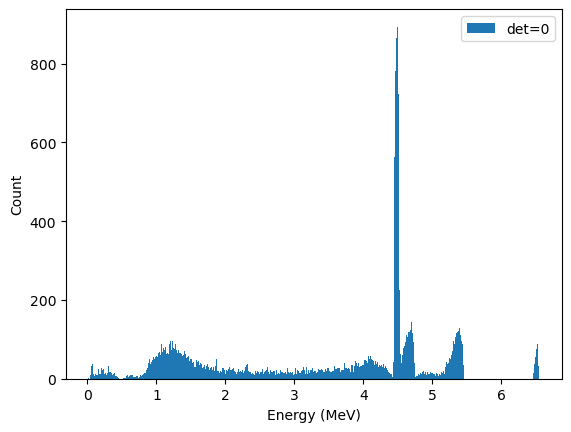

In [13]:
# Concatenate the energies of alpha particles that hit detector 0 and had multiple hits
detector_0 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 0)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 0)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 0)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 0
fig, ax = plt.subplots()
ax.hist(detector_0, bins=500, label="det=0")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

In [14]:
len(detector_0)

17381

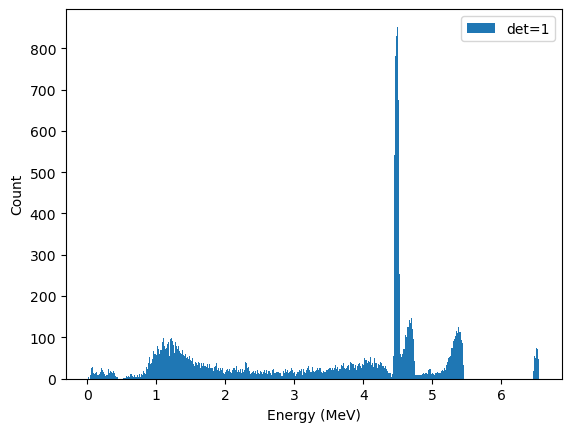

In [15]:
# Concatenate the energies of alpha particles that hit detector 1 and had multiple hits
detector_1 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 1)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 1)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 1)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 1
fig, ax = plt.subplots()
ax.hist(detector_1, bins=500, label="det=1")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

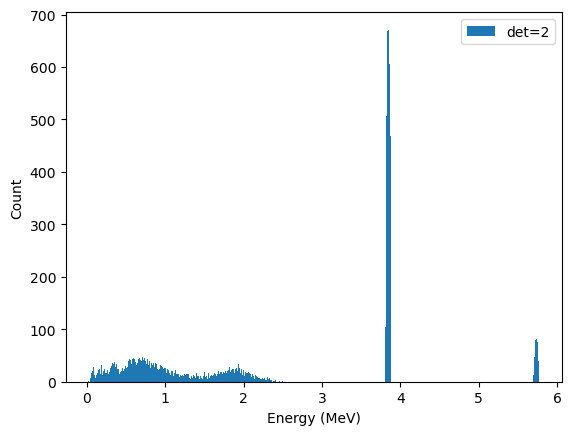

In [16]:
# Concatenate the energies of alpha particles that hit detector 2 and had multiple hits
detector_2 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 2)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 2)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 2)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 2
fig, ax = plt.subplots()
ax.hist(detector_2, bins=500, label="det=2")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

In [17]:
len(detector_2)

7565

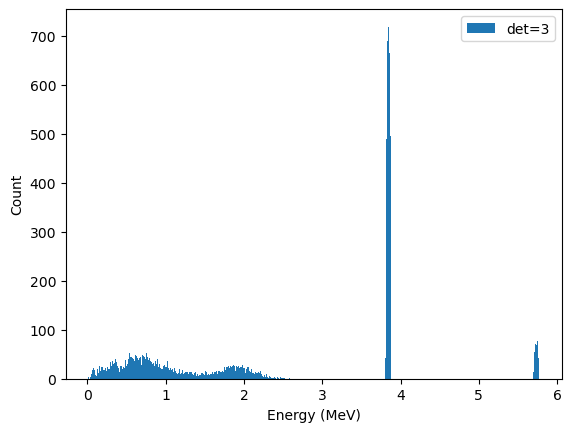

In [18]:
# Concatenate the energies of alpha particles that hit detector 3 and had multiple hits
detector_3 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 3)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 3)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 3)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 3
fig, ax = plt.subplots()
ax.hist(detector_3, bins=500, label="det=3")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

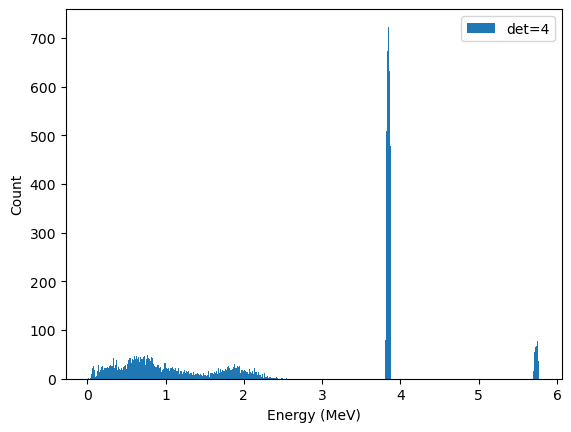

In [19]:
# Concatenate the energies of alpha particles that hit detector 4 and had multiple hits
detector_4 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 4)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 4)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 4)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 4
fig, ax = plt.subplots()
ax.hist(detector_4, bins=500, label="det=4")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

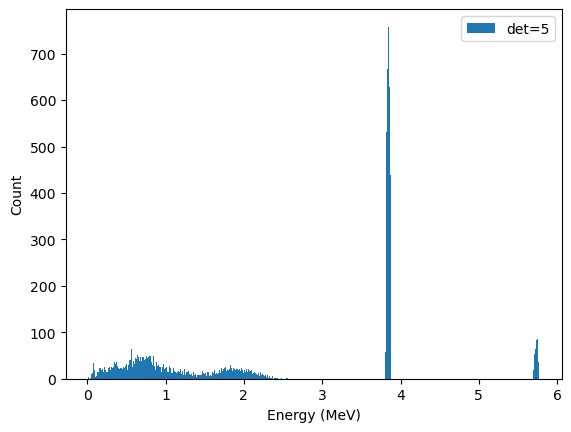

In [20]:
# Concatenate the energies of alpha particles that hit detector 5 and had multiple hits
detector_5 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 5)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 5)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 5)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 5
fig, ax = plt.subplots()
ax.hist(detector_5, bins=500, label="det=5")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

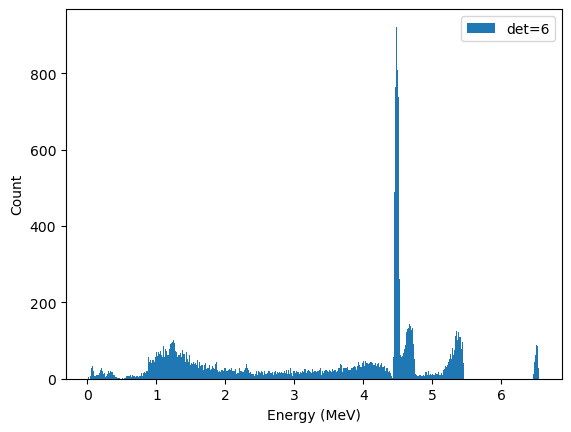

In [21]:
# Concatenate the energies of alpha particles that hit detector 6 and had multiple hits
detector_6 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 6)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 6)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 6)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 6
fig, ax = plt.subplots()
ax.hist(detector_6, bins=500, label="det=6")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

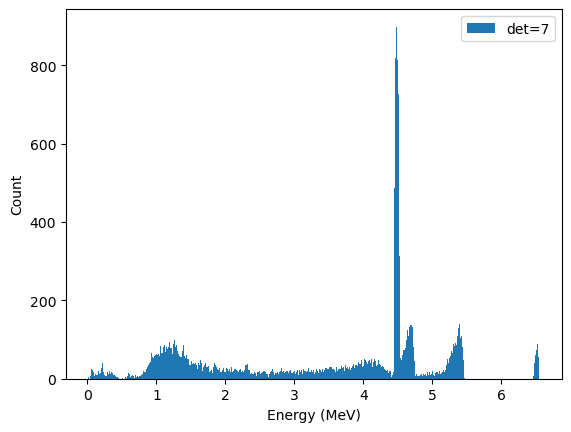

In [22]:
# Concatenate the energies of alpha particles that hit detector 7 and had multiple hits
detector_7 = np.concatenate((
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_01_det"] == 7)].en_a_01,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_11_det"] == 7)].en_a_11,
    alpha_df.loc[(alpha_df["multiple_det"] == True) & (alpha_df["a_12_det"] == 7)].en_a_12
))

# Create a histogram of the energies of alpha particles that hit detector 7
fig, ax = plt.subplots()
ax.hist(detector_7, bins=500, label="det=7")
ax.legend()
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('Count')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

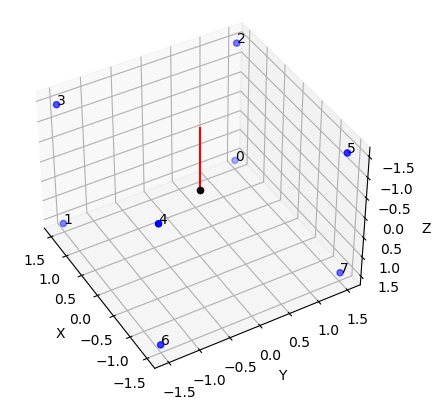

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#detectors
ax.scatter3D(detector_x, detector_y, detector_z, c="blue")

det_num = np.arange(len(detector_x))

for x,y,z,s in zip(detector_x, detector_y, detector_z, det_num):
    ax.text(x, y, z, s)

# ax.plot3D([0, a10_x[0]], [0, a10_y[0]], [0, a10_z[0]], "green")
# ax.plot3D([0, Be_x[0]],[0, Be_y[0]],[0, Be_z[0]], "red")

# ax.plot3D([0, a11_x[0]],[0, a11_y[0]],[0, a11_z[0]], "orange")
# ax.plot3D([0, a12_x[0]],[0, a12_y[0]],[0, a12_z[0]], "pink")

# ax.scatter3D(rx, ry, rz, "green")
# ax.plot3D(rx, ry, rz, "green")

# ax.scatter3D(0, 0, 0, "red")

ax.plot3D([0,0],[0,0],[0,-max(detector_z)], "red")

ax.scatter3D(0,0,0, c="black")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(-140, 30)

plt.show

In [20]:
atoms_per_area

1.3091000000000003e+18

In [8]:
diff_cross_section(zp, zB, mp, mB11, enp, 45)

3.4659480572842456e-24

In [26]:
solid_angle(d, detector_area)

0.01899718381792446

In [19]:
diff_cross_section(zp, zB, mp, mB11, enp, 45)*solid_angle(d, detector_area)*atoms_per_area

8.619540164825234e-08

In [23]:
enp*kinematic_factor(mp,mB11,45)

0.6255210286895171

In [17]:
diff_cross_section(zp, zB, mp, mB11, enp, 135)

1.0082097682801677e-25

In [18]:
diff_cross_section(zp, zB, mp, mB11, enp, 135)*solid_angle(d, detector_area)*atoms_per_area

2.50733838148439e-09

In [24]:
enp*kinematic_factor(mp,mB11,135)

0.482458840549031

In [6]:
diff_cross_section(zp, zB, mp, mB11, enp, 41.05)

4.91925799749787e-24

In [7]:
diff_cross_section(zp, zB, mp, mB11, enp, 48.95)

2.5227763066393654e-24